In [1]:
import json
from sae_lens import SAE, HookedSAETransformer
from functools import partial
import einops
import os
import gc
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.optim as optim
from datasets import load_dataset
from transformers import AutoTokenizer
from transformer_lens.hook_points import (
    HookPoint,
) 
import numpy as np
import pandas as pd
from pprint import pprint as pp
from typing import Tuple
from torch import Tensor
from functools import lru_cache
from typing import TypedDict, Optional, Tuple, Union
from tqdm import tqdm
import random

In [2]:
with open("config.json", 'r') as file:
   config = json.load(file)
token = config.get('huggingface_token', None)
os.environ["HF_TOKEN"] = token

# Define device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

hf_cache = "/work/pi_jensen_umass_edu/jnainani_umass_edu/mechinterp/huggingface_cache/hub"
os.environ["HF_HOME"] = hf_cache

# Load the model
model = HookedSAETransformer.from_pretrained("google/gemma-2-9b", device=device, cache_dir=hf_cache) 

Device: cuda


Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

Loaded pretrained model google/gemma-2-9b into HookedTransformer


In [3]:
pad_token_id = model.tokenizer.pad_token_id
for param in model.parameters():
   param.requires_grad_(False)

device = "cuda"
layers= [7, 14, 21, 40]
l0s = [92, 67, 129, 125]
saes = [SAE.from_pretrained(release="gemma-scope-9b-pt-res", sae_id=f"layer_{layers[i]}/width_16k/average_l0_{l0s[i]}", device=device)[0] for i in range(len(layers))]

In [4]:
!nvidia-smi

Wed Dec 25 20:52:44 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.127.05             Driver Version: 550.127.05     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-80GB          On  |   00000000:1B:00.0 Off |                    0 |
| N/A   31C    P0             68W /  500W |   45027MiB /  81920MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


# utilities

In [5]:
def cleanup_cuda():
   torch.cuda.empty_cache()
   gc.collect()

def clear_memory():
   for sae in saes:
      for param in sae.parameters():
         param.grad = None
      for param in sae.mask.parameters():
         param.grad = None

   for param in model.parameters():
      param.grad = None
   cleanup_cuda()


In [6]:
cleanup_cuda()

# Mask

In [7]:
class SparseMask(nn.Module):
    def __init__(self, shape, l1, seq_len=None, distinct_l1=0):
        super().__init__()
        if seq_len is not None:
            self.mask = nn.Parameter(torch.ones(seq_len, shape))
        else:
            self.mask = nn.Parameter(torch.ones(shape))
        self.l1 = l1
        self.distinct_l1 = distinct_l1
        self.max_temp = torch.tensor(1000.0)
        self.sparsity_loss = None
        self.ratio_trained = 1
        self.temperature = 1
        self.distinct_sparsity_loss = 0


    def forward(self, x, binary=False, mean_ablation=None):
        if binary:
            # binary mask, 0 if negative, 1 if positive
            binarized = (self.mask > 0).float()
            if mean_ablation is None:
                return x * binarized
            else:
                diff = x - mean_ablation
                return diff * binarized + mean_ablation
            

        self.temperature = self.max_temp ** self.ratio_trained
        mask = torch.sigmoid(self.mask * self.temperature)
        self.sparsity_loss = torch.abs(mask).sum() * self.distinct_l1
        if len(mask.shape) == 2:
            self.distinct_sparsity_loss = torch.abs(mask).max(dim=0).values.sum() * self.l1

        if mean_ablation is None:
            return x * mask
        else:
            diff = x - mean_ablation
            return diff * mask + mean_ablation

# for sae in saes:
#     sae.mask = SparseMask(sae.cfg.d_sae, 1.0, seq_len=65)

In [8]:
bos_token_id = model.tokenizer.bos_token_id

def build_sae_hook_fn(
    sae,
    sequence,
    circuit_mask=None,
    use_mask=False,
    binarize_mask=False,
    mean_mask=False,
    ig_mask_threshold=None,
    cache_sae_grads=False,
    cache_masked_activations=False,
    cache_sae_activations=False,
    mean_ablate=False, 
    fake_activations=False):    
    
    mask = torch.ones_like(sequence, dtype=torch.bool)
    mask[sequence == bos_token_id] = False 

    def sae_hook(value, hook):
        # print(f"sae {sae.cfg.hook_name} running at layer {hook.layer()}")
        feature_acts = sae.encode(value)
        feature_acts = feature_acts * mask.unsqueeze(-1)
        if fake_activations != False and sae.cfg.hook_layer == fake_activations[0]:
            feature_acts = fake_activations[1]
        if cache_sae_grads:
            raise NotImplementedError("torch is confusing")
            sae.feature_acts = feature_acts.requires_grad_(True)
            sae.feature_acts.retain_grad()
        
        if cache_sae_activations:
            sae.feature_acts = feature_acts.detach().clone()
        
        # Learned Binary Masking
        if use_mask:
            if mean_mask:
                # apply the mask, with mean ablations
                feature_acts = sae.mask(feature_acts, binary=binarize_mask, mean_ablation=sae.mean_ablation)
            else:
                # apply the mask, without mean ablations
                feature_acts = sae.mask(feature_acts, binary=binarize_mask)

        # IG Masking
        if ig_mask_threshold != None:
            # apply the ig mask
            if mean_mask:
                feature_acts = sae.igmask(feature_acts, threshold=ig_mask_threshold, mean_ablation=sae.mean_ablation)
            else:
                feature_acts = sae.igmask(feature_acts, threshold=ig_mask_threshold)

        if circuit_mask is not None:
            raise NotImplementedError("mask interface not supported")
            mask_method = circuit_mask['mask_method']
            mask_indices = circuit_mask[sae.cfg.hook_name]
            if mask_method == 'keep_only':
                # any activations not in the mask are set to 0
                expanded_circuit_mask = torch.zeros_like(feature_acts)
                expanded_circuit_mask[:, :, mask_indices] = 1
                feature_acts = feature_acts * expanded_circuit_mask
            elif mask_method == 'zero_only':
                feature_acts[:, :, mask_indices] = 0
            else:
                raise ValueError(f"mask_method {mask_method} not recognized")
            
        if cache_masked_activations:
            sae.feature_acts = feature_acts.detach().clone()
        if mean_ablate:
            feature_acts = sae.mean_ablation

        out = sae.decode(feature_acts)
        # choose out or value based on the mask
        mask_expanded = mask.unsqueeze(-1).expand_as(value)
        value = torch.where(mask_expanded, out, value)
        return value
    return sae_hook

def build_hooks_list(sequence,
                    cache_sae_activations=False,
                    cache_sae_grads=False,
                    circuit_mask=None,
                    use_mask=False,
                    binarize_mask=False,
                    mean_mask=False,
                    cache_masked_activations=False,
                    mean_ablate=False,
                    fake_activations: Tuple[int, torch.Tensor] = False,
                    ig_mask_threshold=None,
                    ):
    hooks = []
    for sae in saes:
        hooks.append(
            (
            sae.cfg.hook_name,
            build_sae_hook_fn(sae, sequence, cache_sae_grads=cache_sae_grads, circuit_mask=circuit_mask, use_mask=use_mask, binarize_mask=binarize_mask, cache_masked_activations=cache_masked_activations, cache_sae_activations=cache_sae_activations, mean_mask=mean_mask, mean_ablate=mean_ablate, fake_activations=fake_activations, ig_mask_threshold=ig_mask_threshold),
            )
        )
    return hooks 

def build_sae_logitfn(**kwargs):
    def logitfn(tokens):
        return model.run_with_hooks(
            tokens, 
            return_type="logits", 
            fwd_hooks=build_hooks_list(tokens, **kwargs)
            )
    return logitfn

# Data 

In [9]:
import json
file_path = 'data/sva/rc_train.json'
with open(file_path, 'r') as file:
    data = [json.loads(line) for line in file]
for entry in data:
    print(entry)
    break
example_length = 7

{'clean_prefix': 'The friends that the dancer visits', 'patch_prefix': 'The friend that the dancer visits', 'clean_answer': ' go', 'patch_answer': ' goes', 'case': 'plural_singular'}


In [10]:
from transformer_lens.utils import test_prompt
test_prompt("The athlete that the chefs hate", " are", model)

Tokenized prompt: ['<bos>', 'The', ' athlete', ' that', ' the', ' chefs', ' hate']
Tokenized answer: [' are']


Performance on answer token:
Rank: 49       Logit: 24.10 Prob:  0.09% Token: | are|

Top 0th token. Logit: 29.52 Prob: 20.86% Token: | the|
Top 1th token. Logit: 29.34 Prob: 17.35% Token: | to|
Top 2th token. Logit: 28.84 Prob: 10.49% Token: |.|
Top 3th token. Logit: 28.45 Prob:  7.13% Token: |,|
Top 4th token. Logit: 28.29 Prob:  6.06% Token: | is|
Top 5th token. Logit: 28.13 Prob:  5.18% Token: |

|
Top 6th token. Logit: 28.01 Prob:  4.57% Token: | most|
Top 7th token. Logit: 27.45 Prob:  2.63% Token: |?|
Top 8th token. Logit: 27.33 Prob:  2.33% Token: | and|
Top 9th token. Logit: 27.31 Prob:  2.27% Token: |!|


Ranks of the answer tokens: [(' are', 49)]

In [11]:
clean_data = []
corr_data = []
clean_labels = []
corr_labels = []
for entry in data:
    if model.to_tokens(entry['clean_prefix']).shape[-1] == example_length:
        clean_data.append(entry['clean_prefix'])
        corr_data.append(entry['patch_prefix'])
        clean_labels.append(entry['clean_answer'])
        corr_labels.append(entry['patch_answer'])

In [12]:
N = 10000
clean_tokens = model.to_tokens(clean_data[:N])
corr_tokens = model.to_tokens(corr_data[:N])
clean_label_tokens = model.to_tokens(clean_labels[:N], prepend_bos=False).squeeze(-1)
corr_label_tokens = model.to_tokens(corr_labels[:N], prepend_bos=False).squeeze(-1)
print(clean_tokens.shape, corr_tokens.shape)

torch.Size([10000, 7]) torch.Size([10000, 7])


In [13]:
def logit_diff_fn(logits, clean_labels, corr_labels, token_wise=False):
    clean_logits = logits[torch.arange(logits.shape[0]), -1, clean_labels]
    corr_logits = logits[torch.arange(logits.shape[0]), -1, corr_labels]
    return (clean_logits - corr_logits).mean() if not token_wise else (clean_logits - corr_logits)

In [14]:
batch_size = 16 
clean_tokens = clean_tokens[:batch_size*(len(clean_tokens)//batch_size)]
corr_tokens = corr_tokens[:batch_size*(len(corr_tokens)//batch_size)]
clean_label_tokens = clean_label_tokens[:batch_size*(len(clean_label_tokens)//batch_size)]
corr_label_tokens = corr_label_tokens[:batch_size*(len(corr_label_tokens)//batch_size)]

clean_tokens = clean_tokens.reshape(-1, batch_size, clean_tokens.shape[-1])
corr_tokens = corr_tokens.reshape(-1, batch_size, corr_tokens.shape[-1])
clean_label_tokens = clean_label_tokens.reshape(-1, batch_size)
corr_label_tokens = corr_label_tokens.reshape(-1, batch_size)

print(clean_tokens.shape, corr_tokens.shape, clean_label_tokens.shape, corr_label_tokens.shape)

torch.Size([625, 16, 7]) torch.Size([625, 16, 7]) torch.Size([625, 16]) torch.Size([625, 16])


In [16]:
use_mask = False 
mean_mask = False
avg_logit_diff = 0
cleanup_cuda()
with torch.no_grad():
    for i in range(10):
        logits = model.run_with_hooks(
            clean_tokens[i], 
            return_type="logits", 
            fwd_hooks=build_hooks_list(clean_tokens[i], use_mask=use_mask, mean_mask=mean_mask)
            )
        ld = logit_diff_fn(logits, clean_label_tokens[i], corr_label_tokens[i])
        print(ld)
        avg_logit_diff += ld
        del logits
        cleanup_cuda()
print("Average LD: ", avg_logit_diff / 10)

tensor(2.7792, device='cuda:0')
tensor(3.6336, device='cuda:0')
tensor(3.7514, device='cuda:0')
tensor(3.3448, device='cuda:0')
tensor(3.6474, device='cuda:0')
tensor(4.0851, device='cuda:0')
tensor(3.2005, device='cuda:0')
tensor(3.2937, device='cuda:0')
tensor(3.4509, device='cuda:0')
tensor(3.9535, device='cuda:0')
Average LD:  tensor(3.5140, device='cuda:0')


In [17]:
for sae in saes:
    sae.mask = SparseMask(sae.cfg.d_sae, 1.0, seq_len=example_length).to(device)

In [18]:
def running_mean_tensor(old_mean, new_value, n):
    return old_mean + (new_value - old_mean) / n

def get_sae_means(mean_tokens, total_batches, batch_size, per_token_mask=False):
    for sae in saes:
        sae.mean_ablation = torch.zeros(sae.cfg.d_sae).float().to(device)
    
    with tqdm(total=total_batches*batch_size, desc="Mean Accum Progress") as pbar:
        for i in range(total_batches):
            for j in range(batch_size):
                with torch.no_grad():
                    _ = model.run_with_hooks(
                        mean_tokens[i, j], 
                        return_type="logits", 
                        fwd_hooks=build_hooks_list(clean_tokens[i, j], cache_sae_activations=True)
                        )
                    for sae in saes:
                        sae.mean_ablation = running_mean_tensor(sae.mean_ablation, sae.feature_acts, i+1)
                    cleanup_cuda()
                pbar.update(1)

            if i >= total_batches:
                break

get_sae_means(corr_tokens, 10, 16)

Mean Accum Progress: 100%|██████████| 160/160 [00:45<00:00,  3.54it/s]


In [19]:
logits = model.run_with_hooks(
        clean_tokens[0], 
        return_type="logits", 
        fwd_hooks=build_hooks_list(clean_tokens[0], mean_ablate=True)
        )
print(logit_diff_fn(logits, clean_label_tokens[0], corr_label_tokens[0]))
del logits
cleanup_cuda()

tensor(-0.0714, device='cuda:0', grad_fn=<MeanBackward0>)


# Mask training

In [20]:
import signal
class KeyboardInterruptBlocker:
    def __enter__(self):
        # Block SIGINT and store old mask
        self.old_mask = signal.pthread_sigmask(signal.SIG_BLOCK, {signal.SIGINT})

    def __exit__(self, exc_type, exc_value, traceback):
        # Restore old mask (unblock SIGINT)
        signal.pthread_sigmask(signal.SIG_SETMASK, self.old_mask)

class Range:
    def __init__(self, *args):
        # Support for range(start, stop, step) or range(stop)
        self.args = args

        # Validate input like the built-in range does
        if len(self.args) not in {1, 2, 3}:
            raise TypeError(f"Range expected at most 3 arguments, got {len(self.args)}")
        
        self.range = __builtins__.range(*self.args)  # Create the range object

    def __iter__(self):
        for i in self.range:
            try:
                with KeyboardInterruptBlocker():
                    yield i
            except KeyboardInterrupt:
                print("Keyboard interrupt received. Exiting iteration.")
                break

    def __len__(self):
        return len(self.range)

In [21]:
import torch.nn.functional as F
import wandb

def forward_pass(batch, labels, logitfn, ratio_trained=1):
    for sae in saes:
        sae.mask.ratio_trained = ratio_trained
    tokens = batch
    logits = logitfn(tokens)
    last_token_logits = logits[:, -1, :]
    loss = F.cross_entropy(last_token_logits, labels)
    sparsity_loss = 0
    for sae in saes:
        sparsity_loss = sparsity_loss + sae.mask.sparsity_loss
    
    sparsity_loss = sparsity_loss / len(saes)
    return loss, sparsity_loss

In [22]:
clean_tokens.shape[0]*0.1

62.5

In [26]:
def do_training_run(token_dataset, labels_dataset, corr_labels_dataset, sparsity_multiplier, example_length=6, loss_function='ce', per_token_mask=False, use_mask=False, mean_mask=False, distinct_sparsity_multiplier=0):

    def logitfn(tokens):
        logits =  model.run_with_hooks(
            tokens, 
            return_type="logits", 
            fwd_hooks=build_hooks_list(tokens, use_mask=use_mask, mean_mask=mean_mask)
            )
        return logits

    def forward_pass(batch, labels, logitfn, ratio_trained=1):
        for sae in saes:
            sae.mask.ratio_trained = ratio_trained
        tokens = batch
        logits = logitfn(tokens)
        last_token_logits = logits[:, -1, :]
        loss = F.cross_entropy(last_token_logits, labels)

        sparsity_loss = 0
        if per_token_mask:
            distinct_sparsity_loss = 0
        for sae in saes:
            sparsity_loss = sparsity_loss + sae.mask.sparsity_loss
            if per_token_mask:
                distinct_sparsity_loss = distinct_sparsity_loss + sae.mask.distinct_sparsity_loss
        
        sparsity_loss = sparsity_loss / len(saes)
        distinct_sparsity_loss = distinct_sparsity_loss / len(saes)

        return loss, sparsity_loss, distinct_sparsity_loss

    print("doing a run with sparsity multiplier", sparsity_multiplier)
    all_optimized_params = []
    config = {
        "batch_size": 16,
        "learning_rate": 0.05,
        "total_steps": token_dataset.shape[0]*0.5,
        "sparsity_multiplier": sparsity_multiplier
    }

    for sae in saes:
        if per_token_mask:
            sae.mask = SparseMask(sae.cfg.d_sae, 1.0, seq_len=example_length, distinct_l1=1.0).to(device)
        else:
            sae.mask = SparseMask(sae.cfg.d_sae, 1.0).to(device)
        all_optimized_params.extend(list(sae.mask.parameters()))
        sae.mask.max_temp = torch.tensor(200.0)
    
    wandb.init(project="sae circuits", config=config)
    optimizer = optim.Adam(all_optimized_params, lr=config["learning_rate"])
    total_steps = config["total_steps"] #*config["batch_size"]

    with tqdm(total=total_steps, desc="Training Progress") as pbar:
        for i, (x, y) in enumerate(zip(token_dataset, labels_dataset)):
            with KeyboardInterruptBlocker():
                optimizer.zero_grad()
                
                # Calculate ratio trained
                ratio_trained = i / total_steps
                
                # Update mask ratio for each SAE
                for sae in saes:
                    sae.mask.ratio_trained = ratio_trained
                
                # Forward pass with updated ratio_trained
                loss, sparsity_loss, distinct_sparsity_loss = forward_pass(x, y, logitfn, ratio_trained=ratio_trained)
                if per_token_mask:
                    sparsity_loss = sparsity_loss / example_length

                avg_nonzero_elements = sparsity_loss
                avg_distinct_nonzero_elements = distinct_sparsity_loss
                    
                sparsity_loss = sparsity_loss * config["sparsity_multiplier"] + distinct_sparsity_loss * distinct_sparsity_multiplier
                total_loss = loss + sparsity_loss
                infodict  = {"Step": i, "Progress": ratio_trained, "Avg Nonzero Elements": avg_nonzero_elements.item(), "avg distinct lat/sae":avg_distinct_nonzero_elements.item(), "Task Loss": loss.item(), "Sparsity Loss": sparsity_loss.item(), "temperature": saes[0].mask.temperature}
                wandb.log(infodict)
                
                # Backward pass and optimizer step
                total_loss.backward()
                optimizer.step()
                
                # Update tqdm bar with relevant metrics
                pbar.set_postfix(infodict)
                
                # Update the tqdm progress bar
                pbar.update(1)
                if i >= total_steps*1.3:
                    break
    wandb.finish()

    optimizer.zero_grad()

    for sae in saes:
        for param in sae.parameters():
            param.grad = None
        for param in sae.mask.parameters():
            param.grad = None
    
    for param in model.parameters():
        param.grad = None

    torch.cuda.empty_cache()

    mask_dict = {}

    total_density = 0
    for sae in saes:
        mask_dict[sae.cfg.hook_name] = torch.where(sae.mask.mask > 0)[1].tolist()   # rob thinks .view(-1) needed here
        total_density += (sae.mask.mask > 0).sum().item()
    mask_dict["total_density"] = total_density
    mask_dict['avg_density'] = total_density / len(saes)

    if per_token_mask:
        print("total # latents in circuit: ", total_density)
    print("avg density", mask_dict['avg_density'])

    ### EVAL ###
    def masked_logit_fn(tokens):
        logits =  model.run_with_hooks(
            tokens, 
            return_type="logits", 
            fwd_hooks=build_hooks_list(tokens, use_mask=use_mask, mean_mask=mean_mask, binarize_mask=True)
            )
        return logits

    def eval_ce_loss(batch, labels, logitfn, ratio_trained=10):
        for sae in saes:
            sae.mask.ratio_trained = ratio_trained
        tokens = batch
        logits = logitfn(tokens)
        last_token_logits = logits[:, -1, :]
        loss = F.cross_entropy(last_token_logits, labels)
        return loss
    
    def eval_logit_diff(batch, clean_labels, corr_labels, logitfn, ratio_trained=10):
        for sae in saes:
            sae.mask.ratio_trained = ratio_trained
        tokens = batch
        logits = logitfn(tokens)
        return logit_diff_fn(logits, clean_labels, corr_labels)

    with torch.no_grad():
        loss = eval_ce_loss(token_dataset[-1], labels_dataset[-1], masked_logit_fn)
        print("CE loss:", loss)
        cleanup_cuda()
        logit_diff = eval_logit_diff(token_dataset[-1], clean_label_tokens[-1], corr_label_tokens[-1], masked_logit_fn)
        print("Logit Diff:", logit_diff)
        cleanup_cuda()

    save_path = f"masks/sva/rc/{str(sparsity_multiplier)}_run/"
    os.makedirs(save_path, exist_ok=True)
    mask_dict['ce_loss'] = loss.item()
    mask_dict['logit_diff'] = logit_diff.item()
    faithfulness = logit_diff / (avg_logit_diff/10)
    mask_dict['faithfulness'] = faithfulness.item()
    
    for idx, sae in enumerate(saes):
        mask_path = f"sae_mask_{idx}.pt"
        torch.save(sae.mask.state_dict(), os.path.join(save_path,mask_path))
        print(f"Saved mask for SAE {idx} to {mask_path}")

    json.dump(mask_dict, open(os.path.join(save_path,f"{str(sparsity_multiplier)}_run.json"), "w"))

In [52]:
# for sae in saes:
#     sae.mask = SparseMask(sae.cfg.d_sae, 1.0, seq_len=7, distinct_l1=1.0).to(device)

def masked_logit_fn(tokens):
    return model.run_with_hooks(
        tokens, 
        return_type="logits", 
        fwd_hooks=build_hooks_list(tokens, use_mask=True, mean_mask=True, binarize_mask=True)
        )

def eval_ce_loss(batch, labels, logitfn, ratio_trained=10):
    for sae in saes:
        sae.mask.ratio_trained = ratio_trained
    tokens = batch
    logits = logitfn(tokens)
    last_token_logits = logits[:, -1, :]
    loss = F.cross_entropy(last_token_logits, labels)
    return loss

with torch.no_grad():
    loss = eval_ce_loss(clean_tokens[21], clean_label_tokens[21], masked_logit_fn)
    print("CE loss:", loss)
    cleanup_cuda()

CE loss: tensor(4.5691, device='cuda:0')


In [25]:
do_training_run(clean_tokens, clean_label_tokens, corr_label_tokens, 0.1, example_length=7, loss_function="ce", per_token_mask=True, use_mask=True, mean_mask=True)

doing a run with sparsity multiplier 0.1


ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: jnainani (jnainani-university-of-massachusetts-amherst). Use `wandb login --relogin` to force relogin


Training Progress: 408it [02:35,  2.62it/s, Step=407, Progress=1.3, Avg Nonzero Elements=2.68, avg distinct lat/sae=18.5, Task Loss=3.15, Sparsity Loss=0.268, temperature=tensor(992.7993)]                                  


Avg Nonzero Elements,█▇▅▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Progress,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Sparsity Loss,█▇▅▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Task Loss,▄▇█▄▇▅▄▄▃▃▆▄▅▃▆▆▅▄▁▃▄▄▄▆▇▅▄▂▂▅▅▂▂▄▃▄▃▃▁▁
avg distinct lat/sae,█▇▅▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
temperature,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▄▄▅▆▇█
Avg Nonzero Elements,2.67857
Progress,1.3024
Sparsity Loss,0.26786
Step,407


total # latents in circuit:  75
avg density 18.75
CE loss: tensor(4.5838, device='cuda:0')
Logit Diff: tensor(3.3919, device='cuda:0')
Saved mask for SAE 0 to sae_mask_0.pt
Saved mask for SAE 1 to sae_mask_1.pt
Saved mask for SAE 2 to sae_mask_2.pt
Saved mask for SAE 3 to sae_mask_3.pt


In [ ]:
do_training_run(clean_tokens, clean_label_tokens, corr_label_tokens, 0.1, example_length=7, loss_function="ce", per_token_mask=True, use_mask=True, mean_mask=True)

In [28]:
1/100

0.01

In [32]:
num_runs = 10
start = 0.05
end = 1
step = (end-start)/num_runs

for i in range(num_runs):
    sparsity_multiplier = start + i*step
    do_training_run(clean_tokens, clean_label_tokens, corr_label_tokens, sparsity_multiplier, example_length=7, loss_function="ce", per_token_mask=True, use_mask=True, mean_mask=True)

doing a run with sparsity multiplier 0.05


Training Progress: 408it [02:35,  2.63it/s, Step=407, Progress=1.3, Avg Nonzero Elements=5.29, avg distinct lat/sae=36.8, Task Loss=2.98, Sparsity Loss=0.264, temperature=tensor(992.7993)]                              


Avg Nonzero Elements,█▇▅▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Progress,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Sparsity Loss,█▇▅▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Task Loss,▅▇█▄▇▄▄▃▂▃▆▄▄▃▅▅▄▃▁▃▄▄▄▅▆▄▄▂▂▅▅▂▂▄▃▃▃▃▁▁
avg distinct lat/sae,█▇▅▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
temperature,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▄▄▅▆▇█
Avg Nonzero Elements,5.28571
Progress,1.3024
Sparsity Loss,0.26429
Step,407


total # latents in circuit:  148
avg density 37.0
CE loss: tensor(4.3122, device='cuda:0')
Logit Diff: tensor(3.8150, device='cuda:0')
Saved mask for SAE 0 to sae_mask_0.pt
Saved mask for SAE 1 to sae_mask_1.pt
Saved mask for SAE 2 to sae_mask_2.pt
Saved mask for SAE 3 to sae_mask_3.pt
doing a run with sparsity multiplier 0.14500000000000002


Training Progress: 408it [02:34,  2.64it/s, Step=407, Progress=1.3, Avg Nonzero Elements=1.96, avg distinct lat/sae=13.8, Task Loss=3.21, Sparsity Loss=0.285, temperature=tensor(992.7993)]                                  


Avg Nonzero Elements,█▇▅▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Progress,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Sparsity Loss,█▇▅▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Task Loss,▄▇█▄▇▅▄▄▃▄▇▄▅▃▆▆▅▄▁▃▅▄▄▆▇▅▄▂▂▆▅▂▂▅▃▄▃▃▁▂
avg distinct lat/sae,█▇▅▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
temperature,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▄▄▅▆▇█
Avg Nonzero Elements,1.96429
Progress,1.3024
Sparsity Loss,0.28482
Step,407


total # latents in circuit:  55
avg density 13.75
CE loss: tensor(4.7220, device='cuda:0')
Logit Diff: tensor(3.2238, device='cuda:0')
Saved mask for SAE 0 to sae_mask_0.pt
Saved mask for SAE 1 to sae_mask_1.pt
Saved mask for SAE 2 to sae_mask_2.pt
Saved mask for SAE 3 to sae_mask_3.pt
doing a run with sparsity multiplier 0.24


Training Progress: 408it [02:34,  2.64it/s, Step=407, Progress=1.3, Avg Nonzero Elements=1.21, avg distinct lat/sae=8.5, Task Loss=3.36, Sparsity Loss=0.291, temperature=tensor(992.7993)]                                   


Avg Nonzero Elements,█▇▅▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Progress,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Sparsity Loss,█▇▅▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Task Loss,▄▇█▄▇▅▄▄▃▄▇▅▅▄▇▇▅▄▁▃▅▄▅▆▇▆▅▂▃▆▆▃▃▅▃▄▄▃▁▂
avg distinct lat/sae,█▇▅▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
temperature,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▄▄▅▆▇█
Avg Nonzero Elements,1.21429
Progress,1.3024
Sparsity Loss,0.29143
Step,407


total # latents in circuit:  34
avg density 8.5
CE loss: tensor(4.8299, device='cuda:0')
Logit Diff: tensor(2.9104, device='cuda:0')
Saved mask for SAE 0 to sae_mask_0.pt
Saved mask for SAE 1 to sae_mask_1.pt
Saved mask for SAE 2 to sae_mask_2.pt
Saved mask for SAE 3 to sae_mask_3.pt
doing a run with sparsity multiplier 0.335


Training Progress: 408it [02:35,  2.63it/s, Step=407, Progress=1.3, Avg Nonzero Elements=1.04, avg distinct lat/sae=7.25, Task Loss=3.39, Sparsity Loss=0.347, temperature=tensor(992.7993)]                                  


Avg Nonzero Elements,█▇▅▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Progress,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Sparsity Loss,█▇▅▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Task Loss,▄▆█▄█▅▄▄▃▄▇▅▅▄▇▇▅▄▁▃▅▄▅▆▇▆▅▂▃▆▆▃▃▅▃▄▄▃▁▂
avg distinct lat/sae,█▇▅▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
temperature,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▄▄▅▆▇█
Avg Nonzero Elements,1.03571
Progress,1.3024
Sparsity Loss,0.34696
Step,407


total # latents in circuit:  29
avg density 7.25
CE loss: tensor(4.8583, device='cuda:0')
Logit Diff: tensor(2.2212, device='cuda:0')
Saved mask for SAE 0 to sae_mask_0.pt
Saved mask for SAE 1 to sae_mask_1.pt
Saved mask for SAE 2 to sae_mask_2.pt
Saved mask for SAE 3 to sae_mask_3.pt
doing a run with sparsity multiplier 0.43


Training Progress: 408it [02:34,  2.63it/s, Step=407, Progress=1.3, Avg Nonzero Elements=0.821, avg distinct lat/sae=5.75, Task Loss=3.49, Sparsity Loss=0.353, temperature=tensor(992.7993)]                                 


Avg Nonzero Elements,█▇▅▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Progress,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Sparsity Loss,█▇▅▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Task Loss,▄▆█▄█▅▄▄▃▄▇▅▅▄▇▇▅▄▁▃▅▅▅▆█▆▅▂▃▆▆▃▃▅▄▄▄▃▁▂
avg distinct lat/sae,█▇▅▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
temperature,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▄▄▅▆▇█
Avg Nonzero Elements,0.82143
Progress,1.3024
Sparsity Loss,0.35321
Step,407


total # latents in circuit:  23
avg density 5.75
CE loss: tensor(4.9671, device='cuda:0')
Logit Diff: tensor(2.2081, device='cuda:0')
Saved mask for SAE 0 to sae_mask_0.pt
Saved mask for SAE 1 to sae_mask_1.pt
Saved mask for SAE 2 to sae_mask_2.pt
Saved mask for SAE 3 to sae_mask_3.pt
doing a run with sparsity multiplier 0.525


Training Progress: 408it [02:34,  2.64it/s, Step=407, Progress=1.3, Avg Nonzero Elements=0.786, avg distinct lat/sae=5.5, Task Loss=3.43, Sparsity Loss=0.412, temperature=tensor(992.7993)]                                  


Avg Nonzero Elements,█▇▅▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Progress,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Sparsity Loss,█▇▅▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Task Loss,▄▆█▄█▅▄▄▃▄▇▅▅▄▇▇▅▄▁▃▅▅▅▆█▆▅▂▂▆▆▂▂▅▃▄▄▃▁▂
avg distinct lat/sae,█▇▅▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
temperature,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▄▄▅▆▇█
Avg Nonzero Elements,0.78571
Progress,1.3024
Sparsity Loss,0.4125
Step,407


total # latents in circuit:  22
avg density 5.5
CE loss: tensor(5.0393, device='cuda:0')
Logit Diff: tensor(2.2746, device='cuda:0')
Saved mask for SAE 0 to sae_mask_0.pt
Saved mask for SAE 1 to sae_mask_1.pt
Saved mask for SAE 2 to sae_mask_2.pt
Saved mask for SAE 3 to sae_mask_3.pt
doing a run with sparsity multiplier 0.6200000000000001


Training Progress: 408it [02:34,  2.63it/s, Step=407, Progress=1.3, Avg Nonzero Elements=0.679, avg distinct lat/sae=4.75, Task Loss=3.55, Sparsity Loss=0.421, temperature=tensor(992.7993)]                                 


Avg Nonzero Elements,█▇▅▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Progress,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Sparsity Loss,█▇▅▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Task Loss,▄▆█▄█▅▅▄▃▄▇▅▅▄▇▇▅▄▁▃▅▅▅▇█▆▅▂▃▆▆▃▃▅▃▄▄▃▁▂
avg distinct lat/sae,█▇▅▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
temperature,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▄▄▅▆▇█
Avg Nonzero Elements,0.67857
Progress,1.3024
Sparsity Loss,0.42071
Step,407


total # latents in circuit:  19
avg density 4.75
CE loss: tensor(5.0470, device='cuda:0')
Logit Diff: tensor(2.1821, device='cuda:0')
Saved mask for SAE 0 to sae_mask_0.pt
Saved mask for SAE 1 to sae_mask_1.pt
Saved mask for SAE 2 to sae_mask_2.pt
Saved mask for SAE 3 to sae_mask_3.pt
doing a run with sparsity multiplier 0.7150000000000001


Training Progress: 408it [02:35,  2.63it/s, Step=407, Progress=1.3, Avg Nonzero Elements=0.607, avg distinct lat/sae=4.25, Task Loss=3.56, Sparsity Loss=0.434, temperature=tensor(992.7993)]                                 


Avg Nonzero Elements,█▇▅▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Progress,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Sparsity Loss,█▇▅▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Task Loss,▃▆█▄█▅▅▄▃▄▇▅▅▄▇▇▅▄▂▃▅▅▅▇█▆▅▂▃▆▆▃▃▅▃▄▄▃▁▂
avg distinct lat/sae,█▇▅▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
temperature,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▄▄▅▆▇█
Avg Nonzero Elements,0.60714
Progress,1.3024
Sparsity Loss,0.43411
Step,407


total # latents in circuit:  17
avg density 4.25
CE loss: tensor(5.0593, device='cuda:0')
Logit Diff: tensor(2.0622, device='cuda:0')
Saved mask for SAE 0 to sae_mask_0.pt
Saved mask for SAE 1 to sae_mask_1.pt
Saved mask for SAE 2 to sae_mask_2.pt
Saved mask for SAE 3 to sae_mask_3.pt
doing a run with sparsity multiplier 0.81


Training Progress: 408it [02:35,  2.63it/s, Step=407, Progress=1.3, Avg Nonzero Elements=0.464, avg distinct lat/sae=3.25, Task Loss=3.65, Sparsity Loss=0.376, temperature=tensor(992.7993)]                                 


Avg Nonzero Elements,█▇▅▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Progress,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Sparsity Loss,█▇▅▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Task Loss,▃▆█▄█▅▅▄▃▄▇▅▅▄▇▇▅▅▁▄▅▅▅▇█▆▅▃▃▆▆▃▃▅▃▄▄▃▁▂
avg distinct lat/sae,█▇▅▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
temperature,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▄▄▅▆▇█
Avg Nonzero Elements,0.46429
Progress,1.3024
Sparsity Loss,0.37607
Step,407


total # latents in circuit:  13
avg density 3.25
CE loss: tensor(5.1668, device='cuda:0')
Logit Diff: tensor(1.9893, device='cuda:0')
Saved mask for SAE 0 to sae_mask_0.pt
Saved mask for SAE 1 to sae_mask_1.pt
Saved mask for SAE 2 to sae_mask_2.pt
Saved mask for SAE 3 to sae_mask_3.pt
doing a run with sparsity multiplier 0.905


Training Progress: 408it [02:34,  2.63it/s, Step=407, Progress=1.3, Avg Nonzero Elements=0.429, avg distinct lat/sae=3, Task Loss=3.67, Sparsity Loss=0.388, temperature=tensor(992.7993)]                                    


Avg Nonzero Elements,█▇▅▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Progress,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Sparsity Loss,█▇▅▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Task Loss,▃▆█▄█▅▅▄▃▄▇▅▅▄▇▇▅▅▁▄▅▅▅▇█▆▅▃▃▆▆▃▃▅▃▄▄▃▁▂
avg distinct lat/sae,█▇▅▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
temperature,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▄▄▅▆▇█
Avg Nonzero Elements,0.42857
Progress,1.3024
Sparsity Loss,0.38786
Step,407


total # latents in circuit:  12
avg density 3.0
CE loss: tensor(5.2083, device='cuda:0')
Logit Diff: tensor(1.9963, device='cuda:0')
Saved mask for SAE 0 to sae_mask_0.pt
Saved mask for SAE 1 to sae_mask_1.pt
Saved mask for SAE 2 to sae_mask_2.pt
Saved mask for SAE 3 to sae_mask_3.pt


In [35]:
num_runs = 10
start = 0.05
end = 1
step = (end-start)/num_runs
nnodes = []
faithfulness = []
for i in range(num_runs):
    sparsity_multiplier = start + i*step
    bdir = f"masks/sva/rc/{str(sparsity_multiplier)}_run/{str(sparsity_multiplier)}_run.json"
    # load the dict 
    with open(bdir, 'r') as file:
        mask_dict = json.load(file)
    nnodes.append(mask_dict['avg_density'])
    faithfulness.append(mask_dict['faithfulness'])
    

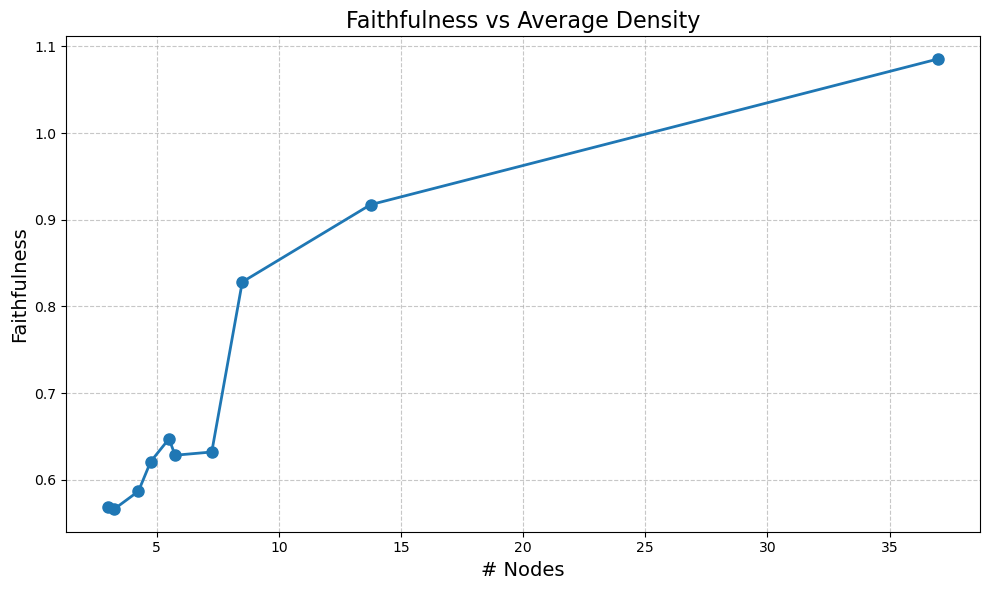

In [37]:
plt.figure(figsize=(10, 6))
plt.plot(nnodes, faithfulness, marker='o', linestyle='-', linewidth=2, markersize=8)

# Add grid for better readability
plt.grid(visible=True, linestyle='--', alpha=0.7)

# Highlight data points
# for x, y in zip(nnodes, faithfulness):
#     plt.scatter(x, y, color='red', edgecolor='black', zorder=5)
#     plt.text(x, y + 0.02, f'({x:.2f}, {y:.2f})', fontsize=9, ha='center')

# Add labels and title
plt.xlabel("# Nodes", fontsize=14)
plt.ylabel("Faithfulness", fontsize=14)
plt.title("Faithfulness vs Average Density", fontsize=16)

# Show the plot
plt.tight_layout()
plt.show()

In [70]:
(saes[3].mask.mask > 0).sum()

tensor(50, device='cuda:0')

In [82]:
actual_mask = {}
for sae in saes: 
    actual_mask[sae.cfg.hook_name] = torch.where(sae.mask.mask > 0)[1].tolist()
actual_mask

{'blocks.7.hook_resid_post': [9152, 4146, 14287],
 'blocks.14.hook_resid_post': [5082, 9224, 11236],
 'blocks.21.hook_resid_post': [7957,
  13730,
  7957,
  12577,
  170,
  209,
  865,
  3687,
  4297,
  4714,
  5141,
  6937,
  8735,
  9502,
  9591,
  10849,
  11008,
  12057,
  15950],
 'blocks.40.hook_resid_post': [23,
  520,
  1035,
  1155,
  1433,
  1452,
  1743,
  1980,
  2235,
  2285,
  2488,
  2664,
  2693,
  2820,
  3111,
  3510,
  3764,
  3765,
  4330,
  4661,
  4740,
  4843,
  6013,
  6214,
  6426,
  6574,
  6851,
  7776,
  7788,
  8003,
  8502,
  8583,
  9294,
  9696,
  10455,
  10702,
  10941,
  11051,
  11314,
  11654,
  12333,
  12905,
  13582,
  13762,
  14357,
  14988,
  15427,
  15600,
  16048,
  16098]}

In [83]:
# save the mask
json.dump(actual_mask, open("updated_01_run.json", "w"))

In [77]:
torch.where(saes[3].mask.mask > 0)[1]

tensor([   23,   520,  1035,  1155,  1433,  1452,  1743,  1980,  2235,  2285,
         2488,  2664,  2693,  2820,  3111,  3510,  3764,  3765,  4330,  4661,
         4740,  4843,  6013,  6214,  6426,  6574,  6851,  7776,  7788,  8003,
         8502,  8583,  9294,  9696, 10455, 10702, 10941, 11051, 11314, 11654,
        12333, 12905, 13582, 13762, 14357, 14988, 15427, 15600, 16048, 16098],
       device='cuda:0')

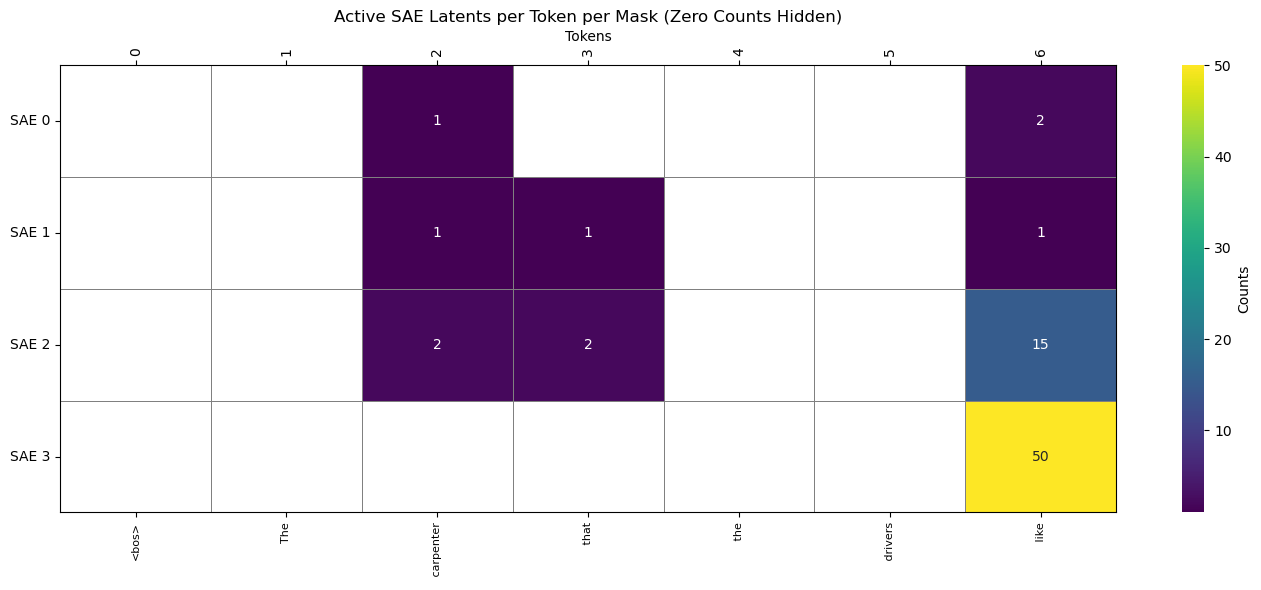

layer 0 latents: 3 🖕
layer 1 latents: 3 🖕
layer 2 latents: 19 🖕
layer 3 latents: 50 🖕
total # latents: 75 🖕


In [72]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap, BoundaryNorm

# Assuming 'saes', 'model', and 'simple_dataset' are defined
tokens = model.to_str_tokens(clean_tokens[2][0])
num_masks = 4 # Number of masks you have
counts_per_mask = []
for mask_index in range(num_masks):
    testmask = saes[mask_index].mask.mask.data.clone()
    binarized = (testmask > 0.0).float()
    counts = []
    for i in range(len(tokens)):
        counts.append(torch.count_nonzero(binarized[i]).item())
    counts_per_mask.append(counts)

# Convert counts to a NumPy array
data = np.array(counts_per_mask) # Shape: (num_masks, num_tokens)

# Create a mask for zero values
zero_mask = data == 0

# Define a colormap
cmap = sns.color_palette("viridis", as_cmap=True)

# Plot the heatmap with the mask
plt.figure(figsize=(14, 6))
ax = sns.heatmap(
    data,
    annot=True,
    fmt='d',
    cmap=cmap,
    mask=zero_mask,
    cbar_kws={'label': 'Counts'},
    linewidths=0.5,
    linecolor='gray'
)

# Set x-axis labels to tokens
ax.set_xticks(np.arange(len(tokens)) + 0.5)
ax.set_xticklabels(tokens, rotation=90, fontsize=8)

# Add numeric indices above the chart
ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(np.arange(len(tokens)) + 0.5)
ax2.set_xticklabels(np.arange(len(tokens)), rotation=90)  # Rotate indices 90 degrees
ax2.set_xlabel('Token Indices')

# Set y-axis labels to masks
ax.set_yticks(np.arange(num_masks) + 0.5)
ax.set_yticklabels([f'SAE {i}' for i in range(num_masks)], rotation=0)

plt.xlabel('Tokens')
plt.ylabel('SAE Number Active Latents')
plt.title('Active SAE Latents per Token per Mask (Zero Counts Hidden)')
plt.tight_layout()
plt.show()

# print the total # latents in the circuit
total_latents = 0
for i, sae in enumerate(saes):
    print(f"layer {i} latents: {torch.sum(sae.mask.mask > 0)} 🖕")
    total_latents += torch.sum(sae.mask.mask > 0)
print(f"total # latents: {total_latents} 🖕")


In [76]:
torch.nonzero((saes[0].mask.mask>0)[2])

tensor([[9152]], device='cuda:0')

# loss calc

In [59]:
logits = model(clean_tokens[21])
probs = F.softmax(logits[torch.arange(logits.shape[0]), -1], dim=-1)
prob_correct = probs[torch.arange(probs.shape[0]), clean_label_tokens[21]].mean().item()
max_prob_idxs = probs.argmax(dim=-1)
top1_acc = (max_prob_idxs == clean_label_tokens[21]).float().mean().item()
print(prob_correct, top1_acc)

0.04241183027625084 0.125


In [61]:
for sae in saes:
    sae.mask = SparseMask(sae.cfg.d_sae, 1.0, seq_len=7, distinct_l1=1.0).to(device)

logits = model.run_with_hooks(
        clean_tokens[21], 
        return_type="logits", 
        fwd_hooks=build_hooks_list(clean_tokens[21], use_mask=False, mean_mask=False) #, binarize_mask=True)
        )
probs = F.softmax(logits[torch.arange(logits.shape[0]), -1], dim=-1)
prob_correct = probs[torch.arange(probs.shape[0]), clean_label_tokens[21]].mean().item()
max_prob_idxs = probs.argmax(dim=-1)
top1_acc = (max_prob_idxs == clean_label_tokens[21]).float().mean().item()
print(prob_correct, top1_acc)

0.054300688207149506 0.1875


In [ ]:
def compute_token_probabilities(logits, labels):
    """Compute probabilities, logit differences, and CE loss for token predictions."""
    # Get probabilities for all tokens at the sequence positions
    probs = F.softmax(logits[torch.arange(logits.shape[0]), -1], dim=-1)
    
    # Calculate mean probabilities for correct and error tokens
    prob_correct = probs[torch.arange(probs.shape[0]), labels].mean().item()
    max_prob_idxs = probs.argmax(dim=-1)
    top1_acc = (max_prob_idxs == labels).float().mean().item()
    # prob_error = get_highest_other_prob(probs, labels).mean().item()
    
    # Calculate logit difference
    correct_logits = logits[torch.arange(logits.shape[0]), -1, labels]
    # error_logits = get_highest_other_logit(logits[torch.arange(logits.shape[0]), -1], labels)
    logit_diff = (correct_logits - error_logits).mean().item()
    
    # Calculate CE loss
    ce_loss = F.cross_entropy(
        logits[torch.arange(logits.shape[0]), -1], 
        labels
    ).item()
    
    return prob_correct, prob_error, logit_diff, top1_acc, ce_loss